# Assignment — Graph Neural Networks

In [1]:
import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import GATConv, SAGEConv

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from zlib import adler32
from IPython.display import clear_output

Using backend: pytorch


### PyTorch quick start

Here are the basics of PyTourch. Skip this section if you are familiar with this material. 

We want to find a function that as close as possible to the sin with some noise 

$$y = \sin(x) + \varepsilon$$

First, let us generate the point cloud.

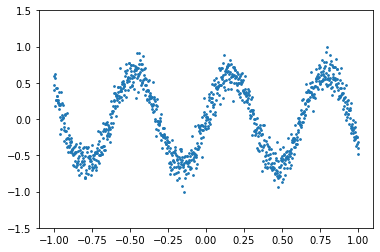

In [2]:
N = 1000
X = np.linspace(-10, 10, N)
np.random.seed(0)
y = np.sin(X) + np.random.normal(0, 0.2, N)
X = minmax_scale(X, (-1, 1))
y = minmax_scale(y, (-1, 1))
plt.scatter(X, y, s=3)
plt.ylim(-1.5, 1.5);

Next, convert np.arrays into tensors via `torch.FloatTensor` (float type) or `torch.LongTensor` (int type).

In [3]:
X_tensor = torch.FloatTensor(X[:, None])
y_tensor = torch.FloatTensor(y[:, None])

Build a model, here is a simple shallow perceptron with layer sizes $1 \to 64 \to 64 \to 1$ so that

$$y = f(x)$$

where $f$ is a neural net, $x$ is a given input real value, $y$ is a output real value.

In [4]:
model = nn.Sequential(nn.Linear(1, 64),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))

the loss function be mean squeared error between the true dependency and approximation.

$$\text{Error} = \frac{1}{N}\sum_i^N \left(\sin(x_i) + \varepsilon - f(x_i)\right)^2$$

In [5]:
MSE = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.005)

The train loop constists of: computing loss, grad, making a step to the optimum.

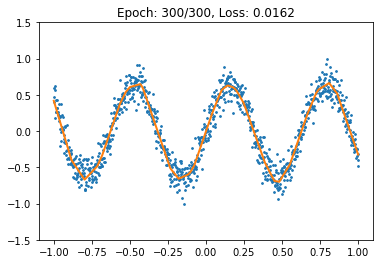

In [6]:
n_epochs = 300
for i in range(n_epochs):
    
    y_pred = model.forward(X_tensor)
    loss = MSE(y_pred, y_tensor)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    plt.scatter(X, y, s=3)
    plt.plot(X, y_pred.detach().numpy(), linewidth=2, c='tab:orange')
    plt.title('Epoch: {}/{}, Loss: {:.4f}'.format(i+1, n_epochs, loss.item()))
    plt.ylim(-1.5, 1.5)
    plt.show()
    clear_output(wait=True)

### Task 1. Graph convolutional network (1 point)

In the task, we will train the Graph Convolutional Network (GCN) model to predict the node label. In the cora dataset, to predict the category of the paper. Let us build the cora dataset.

In [7]:
data = CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [8]:
G = data[0]
type(G)

dgl.heterograph.DGLHeteroGraph

Here is an one-hot encoded feature matrix

In [9]:
features = G.ndata['feat']
features.shape

torch.Size([2708, 1433])

In [10]:
features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

And labels of categories.

In [11]:
labels = G.ndata['label']
labels

tensor([3, 4, 4,  ..., 3, 3, 3])

Train and test masks are tensors with boolean values that define which nodes are train and test.

In [12]:
train_mask = G.ndata['train_mask']
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [13]:
test_mask = G.ndata['test_mask']
test_mask

tensor([False, False, False,  ...,  True,  True,  True])

Zero in-degree nodes will lead to invalid output value. This is because no message will be passed to those nodes, the aggregation function will be appied on empty input. A common practice to avoid this is to add a self-loop for each node in the graph.

In [14]:
G = dgl.add_self_loop(data[0])
G.adjacency_matrix().to_dense()[0, 0]

tensor(1.)

Graph convolution mathematically is defined as follows:

$$h_i^{l+1} = \sigma\left(b^{l} + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_j^{l}W^{l}\right)$$

where $\mathcal{N}(i)$ is the set of neighbors of node $i$,$c_{ij}$ is the product of the square root of node degrees (i.e.,  $c_{ij} = \sqrt{|\mathcal{N}(i)|}\sqrt{|\mathcal{N}(j)|}$), and $\sigma$ is an activation function.


The `GCNLayer` works as follows:

1. Apply linear layer to the hidden state
2. Multiply the result by the normalization `self.norm`
3. Aggregate data over neighbourhood multiplying adjacency matrix by the result
4. Multiply the result by the normalization `self.norm`
5. Return the result

In [15]:
class GCNLayer(nn.Module):
    def __init__(self,
                 g: nx.Graph,
                 in_feats: int,
                 out_feats: int,
                 dropout: float = None):
        super(GCNLayer, self).__init__()
        adj = nx.to_numpy_array(g)
        self.adj = torch.FloatTensor(adj)
        norm = 1 / adj.sum(axis=0)**(1/2)
        self.norm = torch.FloatTensor(norm)[:, None]
        self.linear = nn.Linear(in_feats, out_feats)
        if dropout:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = 0.

    def forward(self, h):
        if self.dropout and self.training:
            h = self.dropout(h)
        res = self.norm * self.adj @ (self.linear(h) * self.norm)
        return res

In [16]:
layer = GCNLayer(G.to_networkx(), in_feats=100, out_feats=10, dropout=0.1)
with torch.no_grad():
    assert layer(torch.randn(100)).shape == (2708, 10)

Complete the class `GCN`. Use `GCNLayer` layers with sizes $1433 \to 16 \to 7$. Here is the zero dropout in the first layer, and the given dropout in the second one. Use the `F.relu` activation after the first layer.

In [17]:
class GCN(nn.Module):
    def __init__(self, g, dropout):
        super(GCN, self).__init__()
        self.conv1 = GCNLayer(g, 1433, 16)
        self.conv2 = GCNLayer(g, 16, 7, dropout)
    def forward(self, features):
        res = self.conv1(features)
        res = F.relu(res)
        res = self.conv2(res)
        return res

In [18]:
model = GCN(G.to_networkx(), dropout=0.1)
assert adler32(str(model).encode()) == 4004464339
with torch.no_grad():
    assert model(torch.randn(1433)).shape == (2708, 7)

For classification tasks we will use `CrossEntropy` loss. Change an optimizer if you wish.

In [19]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

Complete the train loop. To speed up calculation test loss, use `torch.no_grad()`

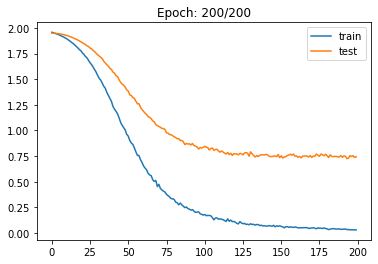

In [20]:
n_epochs = 200
log = []
for i in range(n_epochs):
    opt.zero_grad()
    
    preds = model(features)  
    train_loss = CrossEntropy(preds[train_mask], labels[train_mask])
    train_loss.backward()
    opt.step()
    
    with torch.no_grad():
        test_loss = CrossEntropy(preds[test_mask], labels[test_mask])
    
    log.append([train_loss.item(), test_loss.item()])
    
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    plt.show()
    clear_output(wait=True)

In [21]:
model.eval()
logits = model.forward(features)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(labels[test_mask], y_pred)
assert score > 0.75
print('Balanced accuracy: {:.2f}'.format(score))

Balanced accuracy: 0.81


### Task 2. Graph autoencoder (2 points)

In the previous task, we have trained our model with supervised loss in the node classification task.

One can train GNN in unsupervised fashion. To do so we can state our problem as a graph autoencoder. We will train embeddings in the way to reconstruct adjacency matrix.

We will decode our adjacency matrix with `InnerProductDecoder` class.

You need to implement `forward` function. It works as follows:

1. Apply dropout layer if dropout rate > 0 and not None and we are in train mode.
2. Multiply embeddings matrix and transposed embedding matrix
3. Apply activation if it is not None

In [22]:
class InnerProductDecoder(nn.Module):
    def __init__(self, activation=torch.sigmoid, dropout=0.1):
        super(InnerProductDecoder, self).__init__()
        if dropout is not None:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = None
        self.activation = activation
    
    def forward(self, h):
        if self.dropout and self.training:
            h = self.dropout(h)
        res = h @ h.T
        if self.activation is not None:
            res = self.activation(res)
        return res

In [23]:
decoder = InnerProductDecoder(torch.sigmoid, dropout=None)
adj = decoder(torch.Tensor(np.arange(10).reshape(5, 2)))
assert round(float(adj.numpy()[0, 0]), 4) == 0.7311

`ReconstructionLoss` function takes dgl.Graph as a parameter. After initialization, it should extract adjacency from the graph as a dense tensor, and calculate `pos_weight` as $(N^2 - E) / E$, where $N$ is a number of nodes and $E$ is a number of edges.

Implement `__call__` function that calculates `F.binary_cross_entropy_with_logits` between predicted_adjacency and real adjacency of a graph with `pos_weight`.

*Hint: to obtain dense adjacency matrix, use `g.adjacency_matrix().to_dense()`*

In [24]:
class ReconstructionLoss:
    def __init__(self, g):
        self.adj = g.adjacency_matrix().to_dense()
        num_nodes = self.adj.shape[0]
        num_edges = self.adj.sum().item()
        self.pos_weight = torch.tensor((num_nodes ** 2 - num_edges) / num_edges)
    
    def __call__(self, predicted_adjacency):
        loss = F.binary_cross_entropy_with_logits(predicted_adjacency, self.adj, pos_weight=self.pos_weight)
        return loss

In [25]:
rec_loss = ReconstructionLoss(G)
assert round(rec_loss(G.adjacency_matrix().to_dense()).item(), 3) == 1.005

Complete the train loop so that node embeddings obtained from the GCN model are fed to the decoder, reconstruction loss of a predicted adjacency matrix is computed and then an optimization step is performed.

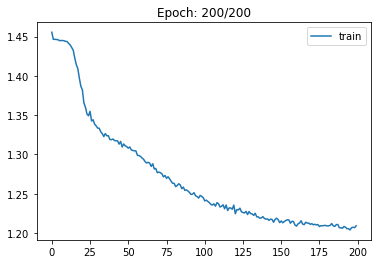

In [26]:
n_epochs = 200

log = []

model = nn.Sequential(
    GCNLayer(G.to_networkx(), 1433, 16, 0.1),
    nn.ReLU(),
    GCNLayer(G.to_networkx(), 16, 16, 0.5),
)
decoder = InnerProductDecoder()
rec_loss = ReconstructionLoss(G)
opt = torch.optim.Adam(model.parameters(), lr=0.05)

for i in range(n_epochs):
    opt.zero_grad()
    
    embeddings = model(features)
    predicted_adjacency = decoder(embeddings)
    train_loss = rec_loss(predicted_adjacency)
    train_loss.backward()
    opt.step()
    
    log.append([train_loss.item()])
    
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train'])
    plt.show()
    clear_output(wait=True)

Now we will validate how unsupervised embeddings will work for node classification task

In [27]:
from sklearn.linear_model import LogisticRegression

model.eval()
emb = model.forward(features).data.numpy()
labs = labels.numpy()

lr = LogisticRegression(max_iter=1000)
lr.fit(emb[train_mask], labs[train_mask])

y_true = labs[test_mask]
y_pred = lr.predict(emb[test_mask])
score = balanced_accuracy_score(y_true, y_pred)
assert score > 0.4
print('Balanced accuracy: {:.2f}'.format(score))

Balanced accuracy: 0.56


### Task 3. Graph attention network (3 point)

Let us apply Graph Attention Network over an input signal.

$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and node $j$:

$$\alpha_{ij}^{l} = \text{Softmax}_{i} (e_{ij}^{l})$$

$$e_{ij}^{l} = \text{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)$$

In [28]:
data = CoraGraphDataset()
G = data[0]
G = dgl.add_self_loop(G)
features = G.ndata['feat']
labels = G.ndata['label']
train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Complete a class `GAT`. Use `GATConv` layers:
`GATConv(1433, 8, num_heads=8)` $\to$ `GATConv(8*8, 7, num_heads=1)`

In `forward` use 
* `tensor.view(-1, m * n)` to reshape, where `m` is the number of heads, `n` is the number of output dimensions
* `F.elu` activation after reshape
* `tensor.squeeze` to decrease shape `(n_features, 1, out_dim) -> (n_features, out_dim)`

In [29]:
class GAT(nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(1433, 8, num_heads=8)
        self.conv2 = GATConv(8 * 8, 7, num_heads=1)

    def forward(self, G, features):
        res = self.conv1(G, features).view(-1, 64)
        res = F.elu(res)
        res = self.conv2(G, res).squeeze()
        return res

In [30]:
model = GAT()
assert str(model) == 'GAT(\n  (conv1): GATConv(\n    (fc): Linear(in_features=1433, out_features=64, bias=False)\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (attn_drop): Dropout(p=0.0, inplace=False)\n    (leaky_relu): LeakyReLU(negative_slope=0.2)\n  )\n  (conv2): GATConv(\n    (fc): Linear(in_features=64, out_features=7, bias=False)\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (attn_drop): Dropout(p=0.0, inplace=False)\n    (leaky_relu): LeakyReLU(negative_slope=0.2)\n  )\n)'


In [31]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), 
                       lr=0.005, weight_decay=0.0005)

Complete the train loop. To speed up calculation test loss, use `torch.no_grad()`

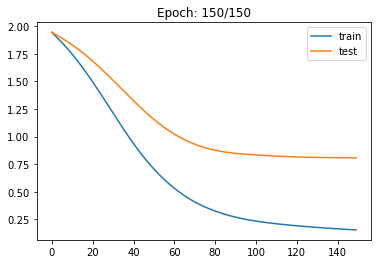

In [32]:
n_epochs = 150

log = []
for i in range(n_epochs):
    opt.zero_grad()
    
    preds = model(G, features)
    train_loss = CrossEntropy(preds[train_mask], labels[train_mask])
    train_loss.backward()
    opt.step()
    
    with torch.no_grad():
        test_loss = CrossEntropy(preds[test_mask], labels[test_mask])
    
    log.append([train_loss.item(), test_loss.item()])
    
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    plt.show()
    clear_output(wait=True)

In [33]:
logits = model.forward(G, features)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(labels[test_mask], y_pred)
assert score > 0.7
print('Balanced accuracy: {:.2f}'.format(score))

Balanced accuracy: 0.78


### Task 4. GraphSAGE (4 points)

Consider GraphSAGE, a representation learning technique suitable for dynamic graphs. GraphSAGE is capable of predicting embedding of a new node, without requiring a re-training procedure. To do so, GraphSAGE learns aggregator functions that can induce the embedding of a new node given its features and neighborhood. This is called inductive learning.

$$h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)$$
$$h_{i}^{(l+1)} = \sigma \left(W \cdot \text{concat}(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)$$
$$h_{i}^{(l+1)} = \mathrm{norm}(h_{i}^{l})$$

Aggregator types here can be `mean`, `gcn`, `pool`, `lstm`. Consider GraphSAGE on the Karate Club graph.

In [34]:
G = nx.karate_club_graph()

labels = [1 if i=='Mr. Hi' else 0 for i in nx.get_node_attributes(G, 'club').values()]
labels = torch.LongTensor(labels)
features = torch.FloatTensor(np.arange(0, 34)[:, None])

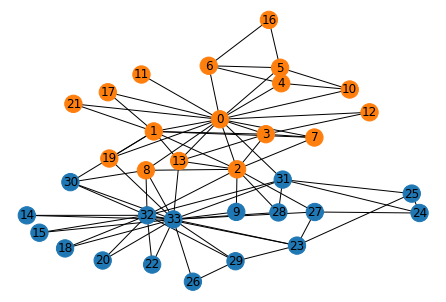

In [35]:
nx.draw_kamada_kawai(
    G, with_labels=True, 
    node_color=['tab:orange' if i==1 else 'tab:blue' for i in labels], 
    cmap=plt.cm.tab10)

Let us delete the node 31, train a model and then return it and predict its label.

In [36]:
idx = np.arange(34)
idx = idx[idx != 31]

New labels and features

In [37]:
labels = labels[idx]
features = features[idx]

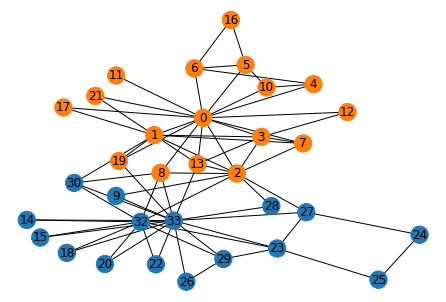

In [38]:
nx.draw_kamada_kawai(
    G.subgraph(idx), with_labels=True, 
    node_color=['tab:orange' if i==1 else 'tab:blue' for i in labels], 
    cmap=plt.cm.tab10)

Let choose test and train nodes

In [39]:
test_idx = [31, 32, 0, 11, 13, 2, 23, 29, 8]
train_idx = list(set(np.arange(33)).difference(test_idx))

Draw the graph, test nodes are gray.

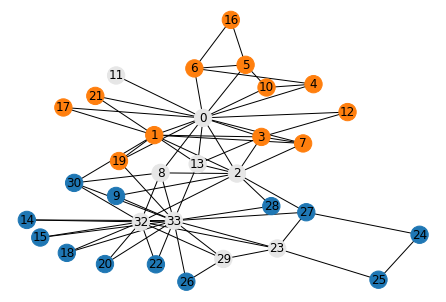

In [40]:
node_color = np.ones((33, 3))
node_color[labels == 0] = plt.cm.tab10(0)[:3]
node_color[labels == 1] = plt.cm.tab10(1)[:3]
node_color[test_idx] = (0.9, 0.9, 0.9)

nx.draw_kamada_kawai(G.subgraph(idx), with_labels=True, 
                     node_color=node_color, cmap=plt.cm.tab10)

Build a dgl graph 

In [41]:
initial_graph = dgl.from_networkx(G.subgraph(idx))
initial_graph

Graph(num_nodes=33, num_edges=144,
      ndata_schemes={}
      edata_schemes={})

Complete a class `SAGE`. Use `SAGEConv` layers with sizes $1 \to 16 \to 2$ and `mean` aggregation function. Put `F.relu` activation after the first layer.

In [42]:
class SAGE(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv(1, 16, aggregator_type="mean")
        self.conv2 = SAGEConv(16, 2, aggregator_type="mean")

    def forward(self, graph, features):
        res = self.conv1(graph, features)
        res = F.relu(res)
        res = self.conv2(graph, res)
        return res

In [43]:
model = SAGE()
assert str(model) == 'SAGE(\n  (conv1): SAGEConv(\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (fc_self): Linear(in_features=1, out_features=16, bias=True)\n    (fc_neigh): Linear(in_features=1, out_features=16, bias=True)\n  )\n  (conv2): SAGEConv(\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (fc_self): Linear(in_features=16, out_features=2, bias=True)\n    (fc_neigh): Linear(in_features=16, out_features=2, bias=True)\n  )\n)'

In [44]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.002)

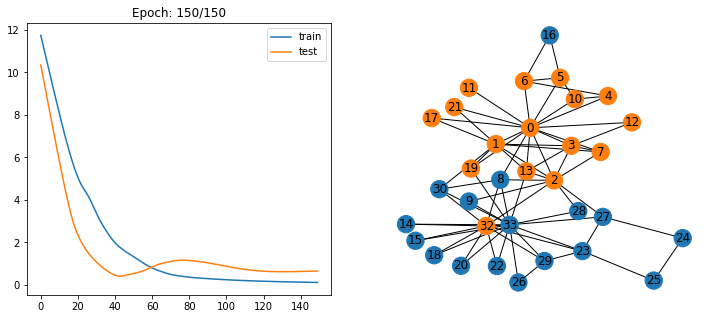

In [45]:
n_epochs = 150

log = []
for i in range(n_epochs):
    
    logits = model.forward(initial_graph, features)
    loss = CrossEntropy(logits[train_idx], labels[train_idx])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        logits = model.forward(initial_graph, features)
        test_loss = CrossEntropy(logits[test_idx], labels[test_idx])
    
    log.append([loss.item(), test_loss.item()])
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    
    y_pred = torch.argmax(logits, 1)
    
    plt.subplot(1, 2, 2)
    nx.draw_kamada_kawai(
        G.subgraph(idx), with_labels=True, 
        node_color=['tab:orange' if i==1 else 'tab:blue' for i in y_pred], 
        cmap=plt.cm.tab10)
    
    
    plt.show()
    clear_output(wait=True)


Let us check that prediction for the node 31 is correct

In [46]:
graph = dgl.from_networkx(G)
labels = [1 if i=='Mr. Hi' else 0 for i in nx.get_node_attributes(G, 'club').values()]
labels = torch.LongTensor(labels)
features = torch.FloatTensor(np.arange(0, 34)[:, None])
predictions = torch.argmax(model(graph, features), 1)
assert predictions[31] == labels[31]